# Report: Analyzing Public Transportation and Traffic Linked to Weather Conditions in Istanbul.

## How do weather variations differ in the relationship between traffic density and public transportation usage in Istanbul?

## 1. Introduction 

Istanbul, with a population of 16 million, faces significant transportation challenges, especially during peak hours, due to its dense population. The city, divided by the Bosphorus, relies on limited transportation options at the connection point of two continents, including three bridges, a submarine tunnel, a metro system, and sea transportation. However, when there is suddenly high demand for a specific option, such as everyone trying to use their cars to cross the bridges, it leads to transportation problems.

At times, vehicle congestion becomes so severe that cars can hardly move, and at other times, long queues form due to the high demand for public transportation, leading to many people being unable to board the arriving vehicles. For an idea of this congestion, a photo of public transportation use during such conditions is provided.

Despite transportation congestion, Istanbul offers a wide variety of transportation options. People in Istanbul can use the following transportation options: private vehicles, buses, minibusses, taxis, metro, tram, ferries, car ferries, and sea taxis. The abundance of options leads to constant changes in people's transportation choices. For instance, someone may prefer ferry travel on a sunny day to enjoy the view of the Bosphorus, while on a rainy day, they might opt for metro transportation to avoid being affected by weather conditions. In some cases, changes may be necessary due to unforeseen circumstances. For example, during stormy weather, ferry services may be suspended, requiring people to use alternative means.

The motivation behind this project is to determine the relationship between the transportation options used in Istanbul and the weather conditions. Through analysis, the project aims to examine how weather conditions influence the connection between traffic congestion and the use of public transportation. By studying these interactions, the project aims to predict in advance which resources will experience increased demand. For example, if there is an increase in public transportation usage, strategically adding extra services may be considered.

## 2. Methods

### 2.1 Data Source

In this project, three different datasets were utilized. The first dataset contains hourly information on Istanbul's location density and traffic. The second dataset includes hourly data on passengers and journeys using public transportation in Istanbul. The third dataset provides information on weather conditions.

#### Data Set 1: Traffic Density Data
- **Data URL:** [Hourly Traffic Density Data Set](https://data.ibb.gov.tr/en/dataset/hourly-traffic-density-data-set)
- The data is shared monthly by the source. To facilitate analysis, data covering the period from October 2022 to September 2023 was downloaded on a monthly basis.
- This dataset includes hourly traffic density information for Istanbul, detailing the number of vehicles at specific locations within one-hour intervals.

##### Columns:
- `DATE_TIME`: Date and time information in YYYY-MM-DD HH24:MI:SS format (hourly).
- `LATITUDE`: Latitude information.
- `LONGITUDE`: Longitude information.
- `GEOHASH`: Geohash value of latitudes and longitudes with a length of 6.
- `MAXIMUM_SPEED`: Maximum speed (in km/h) for the respective geohash area in a given hour.
- `MINIMUM_SPEED`: Minimum speed (in km/h) for the respective geohash area in a given hour.
- `AVERAGE_SPEED`: Average speed (in km/h) for the respective geohash area per hour.
- `NUMBER_OF_VEHICLES`: Number of different vehicles in the relevant geohash area in the given hour.

#### Data Set 2: Public Transport Data
- **Data URL:** [Hourly Public Transport Data Set](https://data.ibb.gov.tr/en/dataset/hourly-public-transport-data-set)
- Similar to the traffic density data, this dataset is shared monthly and covers the period from October 2022 to September 2023.
- The dataset records hourly public transportation usage data in Istanbul, specifying the number of passengers traveling on each mode during one-hour intervals.

##### Columns:
- `transition_date`: Transition date in YYYY-MM-DD format.
- `transition_hour`: Transit time in HH format.
- `transport_type_id`: Mode of transportation used by passengers (1: Highway, 2: Rail, 3: Marine Transportation).
- `road_type`: Area where the types of transportation take place.
- `line`: Line information on which transportation is provided.
- `transfer_type`: Type of transit passengers using public transportation (Transfer: Travel by one or more public transport, Normal: Journey without transfer).
- `number_of_passage`: Number of trips per hour, transfer type, and transportation type.
- `number_of_passenger`: Number of individual passengers traveling in the given hour, depending on the type of transfer and the type of transportation.

#### Data Set 3: Weather Data
- **Data URL:** [Open-Meteo](https://archive-api.open-meteo.com/v1/archive?latitude=41.01&longitude=28.95&start_date=2022-10-01&end_date=2023-09-30&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,windspeed_10m,windspeed_100m&timezone=Europe%2FMoscow&format=csv)
- This dataset includes hourly weather data for Istanbul, encompassing various weather parameters within one-hour intervals.

##### Columns:
- `temperature_2m`: Air temperature at 2 meters above ground.
- `relative_humidity_2m`: Relative humidity at 2 meters above ground.
- `dew_point_2m`: Dew point temperature at 2 meters above ground.
- `apparent_temperature`: Perceived feels-like temperature combining wind chill factor, relative humidity, and solar radiation.
- `precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour.
- `rain`: Rain from large-scale weather systems of the preceding hour in millimeters.
- `snowfall`: Snowfall amount of the preceding hour in centimeters.
- `snow_depth`: Snow depth on the ground.
- `wind_speed_10m`: Wind speed at 10 meters above ground.
- `wind_speed_100m`: Wind speed at 100 meters above ground.

### 2.2 Install dependencies


In this project, sqlite3 has been used for loading data into SQL and reading it back, but it doesn't require installation as it comes pre-installed with Python. Warnings have been suppressed using the warnings library for better output visibility. Data has been stored in tabular form using Pandas, and data manipulations have been performed using Pandas and Numpy. Xgboost and scikit-learn libraries were employed for model creation and analysis of model results. Seaborn and Matplotlib were used for visualizing data and outputs.


In [ ]:
%pip install warnings
%pip install pandas
%pip install numpy
%pip install seaborn 
%pip install matplotlib
%pip install scikit-learn
%pip install xgboost

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor, plot_importance

### 2.3 Data Pipeline and Data Cleaning

When creating the data pipeline, initially, the necessary URLs were defined to access and later store the data. To create a data file using SQL for storage, the location where this file will be created is also specified here. Among these URLs, the URL to access weather data was assigned to the variable `weather_url`. As mentioned in the Data Source section for Traffic Density and Public Transport data, the data was planned to be saved on a monthly basis. Therefore, URLs for each month's source file were stored in dictionaries. URLs were defined within the dictionaries `traffic_density_urls` for Traffic Density and `public_transport_urls` for Public Transport. Lastly, the URL for the SQL file where the data will be stored was assigned to the variable `sql_doc`.

In [2]:
wheather_url= 'https://archive-api.open-meteo.com/v1/archive?latitude=41.01&longitude=28.95&start_date=2022-10-01&end_date=2023-09-30&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,windspeed_10m,windspeed_100m&timezone=Europe%2FMoscow&format=csv'


traffic_density_urls = {
    'oct_22': 'https://data.ibb.gov.tr/en/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/72183a60-d47f-4dc9-b1dc-fced0649dcf5/download/traffic_density_202210.csv',
    'nov_22': 'https://data.ibb.gov.tr/en/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/7f463362-a580-41d9-a86a-a542818e7542/download/traffic_density_202211.csv',
    'dec_22': 'https://data.ibb.gov.tr/en/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/dc788908-2b75-434f-9f3f-ef82ff33a158/download/traffic_density_202212.csv',
    'jan_23': 'https://data.ibb.gov.tr/en/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/42fa7a5f-29f1-4b38-9dfa-ac7c8fe3c77d/download/traffic_density_202301.csv',
    'feb_23': 'https://data.ibb.gov.tr/en/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/366befd8-defd-4f79-a3d2-0e7948c649ff/download/traffic_density_202302.csv',
    'mar_23': 'https://data.ibb.gov.tr/en/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/6a60b03a-bf25-4575-9dce-e21fe0e04e77/download/traffic_density_202303.csv',
    'apr_23': 'https://data.ibb.gov.tr/en/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/ce65562e-0d17-4d7e-8090-9484990a8f2b/download/traffic_density_202304.csv',
    'may_23': 'https://data.ibb.gov.tr/en/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/d0a71c11-47d2-4f98-8745-c9446b10bf18/download/traffic_density_202305.csv',
    'jun_23': 'https://data.ibb.gov.tr/en/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/a99913df-dccc-4b7d-b6e3-963ccb5d27b1/download/traffic_density_202306.csv',
    'jul_23': 'https://data.ibb.gov.tr/en/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/3de18c1e-57c0-4493-9b75-5a896edae0ff/download/traffic_density_202307.csv',
    'agu_23': 'https://data.ibb.gov.tr/en/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/f6a1e2d7-0d9f-4d84-90c6-2729a0869308/download/traffic_density_202308.csv',
    'sep_23': 'https://data.ibb.gov.tr/en/dataset/3ee6d744-5da2-40c8-9cd6-0e3e41f1928f/resource/7b9a35a7-dc9c-4044-b117-1c0003104630/download/traffic_density_202309.csv'
}


public_transport_urls = {
    'oct_22': 'https://data.ibb.gov.tr/en/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/01373a9e-7ce5-4d7a-8969-bdd8d7a1ed15/download/hourly_transportation_202210.csv',
    'nov_22': 'https://data.ibb.gov.tr/en/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/e68869f5-8d10-4483-badd-cdec0ef3bc0e/download/hourly_transportation_202211.csv',
    'dec_22': 'https://data.ibb.gov.tr/en/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/22b57697-4d5c-473c-888e-cc0634e5f48b/download/hourly_transportation_202212.csv',
    'jan_23': 'https://data.ibb.gov.tr/en/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/afc1cec1-fd43-44a9-b5c0-977d3b1d60d7/download/hourly_transportation_202301.csv',
    'feb_23': 'https://data.ibb.gov.tr/en/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/6b430597-11fc-4d31-b0eb-c172c8e0e50d/download/hourly_transportation_202302.csv',
    'mar_23': 'https://data.ibb.gov.tr/en/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/eb32254e-3233-4ac9-ade0-cd056ccfa509/download/hourly_transportation_202303.csv',
    'apr_23': 'https://data.ibb.gov.tr/en/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/862a4927-7d69-4a06-a74e-24f1562d438f/download/hourly_transportation_202304.csv',
    'may_23': 'https://data.ibb.gov.tr/en/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/5782df57-1862-4fa2-80f2-a614254fad57/download/hourly_transportation_202305.csv',
    'jun_23': 'https://data.ibb.gov.tr/en/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/e44351e8-d85c-49c8-abc9-d8d5c9ac34ae/download/hourly_transportation_202306.csv',
    'jul_23': 'https://data.ibb.gov.tr/en/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/f0c798c8-bab4-479e-841b-e82422e38e7f/download/hourly_transportation_202307.csv',
    'agu_23': 'https://data.ibb.gov.tr/en/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/f4bafb5a-94a0-4ae9-8024-523287649579/download/hourly_transportation_202308.csv',
    'sep_23': 'https://data.ibb.gov.tr/en/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/b3f67274-4ebc-4453-8f6b-1dcc1b1bf008/download/hourly_transportation_202309.csv'
}


sql_doc="../data/data.sqlite"

Each dataset has its own variables and methods. Therefore, functions were created for each dataset to read and preprocess the data from the source. Subsequently, a function was established to save these datasets. In summary, a total of 4 functions were utilized to both read and preprocess the data as well as save it.

Firstly, the `pull_public_transport` function is created to read and preprocess Public Transport data. As mentioned earlier, Public Transport data is shared on a monthly basis. Therefore, a for loop is established to process and append the data for each month individually. Within the loop, the CSV file for each month is first read. The `transition_date` and `transition_hour` columns are merged to create a new column named `DATE_TIME`. This new column is then converted to datetime format using the `pd.to_datetime` function, and the `transition_date` and `transition_hour` columns are dropped as they are no longer needed. Subsequently, only the `transport_type_id` and `number_of_passage` variables are included, as they will be used in the analysis. To calculate the total number of different journeys in different modes of transportation, the data is grouped by `DATE_TIME` and `transport_type_id`, and the sum of the `number_of_passage` column is computed. Then, individual DataFrames are assigned for each type of transportation, namely 1: Highway, 2: Rail, and 3: Marine Transportation. It is appropriate to evaluate each mode of transportation separately. These DataFrames for each transportation type are then appended to the main DataFrame created for the respective month. This process is repeated for each month, completing the function.

In [3]:
def pull_public_transport(urls):
    
    
    public_transport_df_type_1 = pd.DataFrame()
    public_transport_df_type_2 = pd.DataFrame()
    public_transport_df_type_3 = pd.DataFrame()
    
    
    for month, url in urls.items():
        df2=pd.read_csv(url)
        df2['DATE_TIME'] = pd.to_datetime(df2['transition_date'] + ' ' + df2['transition_hour'].astype(str) + ':00:00')
        df2.drop(['transition_date', 'transition_hour'], axis=1, inplace=True)
    
        selected_columns =['DATE_TIME','transport_type_id','number_of_passage']
        df3 = df2[selected_columns]
    
        grouped_df2 = df3.groupby(['DATE_TIME', 'transport_type_id']).agg({
        'number_of_passage': 'sum'}).reset_index()
    
        df_transport_type_1 = grouped_df2[grouped_df2['transport_type_id'] == 1].copy()
        df_transport_type_2 = grouped_df2[grouped_df2['transport_type_id'] == 2].copy()
        df_transport_type_3 = grouped_df2[grouped_df2['transport_type_id'] == 3].copy()

        public_transport_df_type_1 = pd.concat([public_transport_df_type_1, df_transport_type_1], ignore_index=True)
        public_transport_df_type_2 = pd.concat([public_transport_df_type_2, df_transport_type_2], ignore_index=True)
        public_transport_df_type_3 = pd.concat([public_transport_df_type_3, df_transport_type_3], ignore_index=True)
    
    
    return public_transport_df_type_1,public_transport_df_type_2,public_transport_df_type_3

Secondly, the `pull_traffic_density` function has been created to read and preprocess Traffic Density data. Similar to Public Transport data, Traffic Density data is shared on a monthly basis. Therefore, a for loop is established to process and append the data for each month individually. Within the loop, the CSV file for each month is read. The `DATE_TIME` column is converted to datetime format using the `pd.to_datetime` function. Subsequently, only the `DATE_TIME`, `AVERAGE_SPEED`, and `NUMBER_OF_VEHICLES` variables are included, as they will be used in the analysis. For each row, it calculates the product of the number of vehicles and average speed and assigns these values to a new column named 'CUM_AVERAGE_SPEED'. Since the data covers traffic information for multiple lanes simultaneously, to find the general situation for Istanbul, it groups the data by the 'DATE_TIME' column and calculates the sum of the 'NUMBER_OF_VEHICLES' and 'CUM_AVERAGE_SPEED' columns for each group. While total speeds were previously calculated with 'CUM_AVERAGE_SPEED', finding average speeds would be more useful in this case. Therefore, the average speed is calculated as 'CUM_AVERAGE_SPEED'/'NUMBER_OF_VEHICLES', and these values are assigned to a new column named 'AVERAGE_SPEED'. The 'CUM_AVERAGE_SPEED' column is then deleted as it is no longer needed. These dataframes created for each month are appended to the main dataframe, completing the function. This way, traffic data for different months is consolidated into a single dataframe.

In [4]:
def pull_traffic_density(urls):
    traffic_density_df = pd.DataFrame()
    
    
    for month, url in urls.items():
        df1=pd.read_csv(url)
        df1['DATE_TIME'] = pd.to_datetime(df1['DATE_TIME'])
        selected_columns = ['DATE_TIME','AVERAGE_SPEED', 'NUMBER_OF_VEHICLES']
        df = df1[selected_columns]
        df['CUM_AVERAGE_SPEED'] = df.apply(lambda row: row['NUMBER_OF_VEHICLES'] * row['AVERAGE_SPEED'], axis=1)

        grouped_df = df.groupby('DATE_TIME').agg({
                            'NUMBER_OF_VEHICLES': 'sum',
                            'CUM_AVERAGE_SPEED': 'sum'
                                }).reset_index()
    
        grouped_df['AVERAGE_SPEED'] = grouped_df.apply(lambda row:  row['CUM_AVERAGE_SPEED']/row['NUMBER_OF_VEHICLES'], axis=1)
        grouped_df.drop('CUM_AVERAGE_SPEED', axis=1, inplace=True)
        traffic_density_df = pd.concat([traffic_density_df, grouped_df], ignore_index=True)
        
        
    return traffic_density_df


Thirdly, the pull_weather function has been created to read and preprocess Weather data. In the source of the data, there is some information about the data in the first two rows, which prevents the data from being read in a tabular format. Therefore, when reading the data, the first two rows are skipped to address this issue.

In [5]:
def pull_weather(url):
    df_weather = pd.read_csv(url, skiprows=2)
    return df_weather

Fourthly, a function named `load` has been created with the main purpose of aiming to save the data to a database. The function first connects to the sql_doc file path using the sqlite3 module and creates a connection (con) with a cursor (cur). Then, the data is written to the table using the to_sql method. If the table already exists, the existing table is replaced with the "replace" option. If the table does not exist, a new table is created. Finally, con.commit() is called to apply the changes to the database, and the connection is closed (con.close()). This way, the DataFrame data is loaded into the SQLite database.

In [6]:
def load(df,db,sql_doc):
    con=sqlite3.connect(sql_doc)
    cur=con.cursor()
    
    df.to_sql(name=db, con=con, if_exists="replace", index=False)

    con.commit()
    con.close()

Finally, the sequence of functions created above, which involves data retrieval, processing, and loading into a database, is executed. This ensures that the data is read from the source, processed, and loaded into the database, completing the pipeline.

In [7]:
if __name__ == '__main__':
    
    public_transport_df_type_1,public_transport_df_type_2,public_transport_df_type_3 = pull_public_transport(public_transport_urls)

    traffic_density_df=pull_traffic_density(traffic_density_urls)

    df_weather=pull_weather(wheather_url)

    load(public_transport_df_type_1,'public_transport_type_1',sql_doc)
    load(public_transport_df_type_2,'public_transport_type_2',sql_doc)
    load(public_transport_df_type_3,'public_transport_type_3',sql_doc)
    
    load(traffic_density_df,'traffic_density',sql_doc)

    load(df_weather,'weather',sql_doc)

## 3. Results

### 3.1 First Interaction with the Data

Before delving into the results, gaining more detailed information about the existing data, examining its structure, can be crucial for making more informed interpretations in future analyses. Therefore, a Data Exploration step was conducted before moving on to correlation analyses and modeling. In this context, to avoid rewriting the same code snippet for each table, a function named `read_table` was created to read the data from the database. This function was employed to read each table separately before proceeding with correlation analyses and modeling.


In [8]:
def read_table(table_name):   
    
    con = sqlite3.connect("../data/data.sqlite")

    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql_query(query, con)
    
    con.close()  
    
    
    return df



In [9]:
df_pt_t1=read_table('public_transport_type_1') #Highway
df_pt_t2=read_table('public_transport_type_2') #Rail
df_pt_t3=read_table('public_transport_type_3') #Marine Transportation
df_td=read_table('traffic_density')
df_wth=read_table('weather') 

To understand the nature of the data and establish the initial contact with the datasets, the `first 5 records` of each table were printed and examined. This allowed for a preliminary exploration of the data and gaining insights into the content of each table.


In [10]:
print("Public Transport Type 1 Table - Highway:")
df_pt_t1.head()

Public Transport Type 1 Table - Highway:


,DATE_TIME,transport_type_id,number_of_passage
0,2022-10-01 00:00:00,1,18887
1,2022-10-01 01:00:00,1,7885
2,2022-10-01 02:00:00,1,4547
3,2022-10-01 03:00:00,1,2807
4,2022-10-01 04:00:00,1,2465


In [11]:
print("\nPublic Transport Type 2 Table - Rail:")
df_pt_t2.head()


Public Transport Type 2 Table - Rail:


,DATE_TIME,transport_type_id,number_of_passage
0,2022-10-01 00:00:00,2,17438
1,2022-10-01 01:00:00,2,7422
2,2022-10-01 02:00:00,2,3151
3,2022-10-01 03:00:00,2,1578
4,2022-10-01 04:00:00,2,1052


In [12]:
print("\nPublic Transport Type 3 Table - Marine Transportation:")
df_pt_t3.head()


Public Transport Type 3 Table - Marine Transportation:


,DATE_TIME,transport_type_id,number_of_passage
0,2022-10-01 00:00:00,3,1943
1,2022-10-01 01:00:00,3,331
2,2022-10-01 02:00:00,3,74
3,2022-10-01 03:00:00,3,63
4,2022-10-01 04:00:00,3,35


In [13]:
print("\nTraffic Density Table:")
df_td.head()


Traffic Density Table:


,DATE_TIME,NUMBER_OF_VEHICLES,AVERAGE_SPEED
0,2022-10-01 00:00:00,166586,63.088243
1,2022-10-01 01:00:00,119051,66.163636
2,2022-10-01 02:00:00,83584,67.227687
3,2022-10-01 03:00:00,70154,68.336503
4,2022-10-01 04:00:00,77208,70.502849


In [14]:
print("\nWeather Table:")
df_wth.head()


Weather Table:


,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h)
0,2022-10-01T00:00,21.4,75,16.8,22.8,0.0,0.0,0.0,0.0,6.7,9.4
1,2022-10-01T01:00,22.5,69,16.5,23.8,0.0,0.0,0.0,0.0,6.4,10.2
2,2022-10-01T02:00,20.3,80,16.6,21.4,0.0,0.0,0.0,0.0,8.0,12.1
3,2022-10-01T03:00,19.2,91,17.7,20.5,0.0,0.0,0.0,0.0,9.9,13.8
4,2022-10-01T04:00,18.2,91,16.7,19.0,0.0,0.0,0.0,0.0,10.7,15.0


To gain insights and have a foundational understanding for our analyses, the `describe` function was applied separately to each table, providing a basic statistical summary that emphasizes the overall distribution, central tendency, spread of the distribution, and outliers in the data. This allowed us to form an initial understanding of the data's general characteristics for further analysis.


In [15]:
print("Statistics for Public Transport Type 1 Table - Highway:")
df_pt_t1.describe().T

Statistics for Public Transport Type 1 Table - Highway:


,count,mean,std,min,25%,50%,75%,max
transport_type_id,8645.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
number_of_passage,8645.0,152414.595257,115067.651247,684.0,27348.0,161547.0,229211.0,463812.0


In [16]:
print("\nStatistics for Public Transport Type 2 Table - Rail:")
df_pt_t2.describe().T


Statistics for Public Transport Type 2 Table - Rail:


,count,mean,std,min,25%,50%,75%,max
transport_type_id,8191.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
number_of_passage,8191.0,124846.016848,91284.918941,1.0,48268.5,125148.0,182266.0,391348.0


In [17]:
print("\nStatistics for Public Transport Type 3 Table - Marine Transportation:")
df_pt_t3.describe().T


Statistics for Public Transport Type 3 Table - Marine Transportation:


,count,mean,std,min,25%,50%,75%,max
transport_type_id,8630.0,3.000000,0.000000,3.0,3.00,3.0,3.0,3.0
number_of_passage,8630.0,8256.726419,7607.631196,1.0,1151.25,7561.5,12604.0,60233.0


In [18]:
print("\nStatistics for Public Transport Type 3 Table - Marine Transportation:")
df_pt_t3.describe().T


Statistics for Public Transport Type 3 Table - Marine Transportation:


,count,mean,std,min,25%,50%,75%,max
transport_type_id,8630.0,3.000000,0.000000,3.0,3.00,3.0,3.0,3.0
number_of_passage,8630.0,8256.726419,7607.631196,1.0,1151.25,7561.5,12604.0,60233.0


In [19]:
print("\nStatistics for Weather Table:")
df_wth.describe().T


Statistics for Weather Table:


,count,mean,std,min,25%,50%,75%,max
temperature_2m (°C),8760.0,15.984829,7.305290,-2.8,10.3,15.20,21.7,38.30
relativehumidity_2m (%),8760.0,74.158676,15.161359,22.0,64.0,76.00,86.0,100.00
dewpoint_2m (°C),8760.0,10.951952,5.813469,-5.3,7.0,10.65,15.6,23.20
apparent_temperature (°C),8760.0,14.328231,8.953940,-7.8,7.5,13.20,21.8,38.60
precipitation (mm),8760.0,0.069680,0.402326,0.0,0.0,0.00,0.0,10.50
rain (mm),8760.0,0.067808,0.399237,0.0,0.0,0.00,0.0,10.50
snowfall (cm),8760.0,0.001311,0.029550,0.0,0.0,0.00,0.0,1.54
snow_depth (m),8760.0,0.000345,0.002953,0.0,0.0,0.00,0.0,0.04
windspeed_10m (km/h),8760.0,15.985365,8.167140,0.0,9.2,15.30,21.7,51.90
windspeed_100m (km/h),8760.0,24.150936,11.566255,0.4,15.5,24.00,31.9,76.40


To ensure data integrity and perform operations of the appropriate data types in analyses, the data was inspected using `dtypes`. This enabled checking the data types, and any discrepancies, if present, could be identified for preemptive measures in future operations.


In [20]:
print("Data Types for Public Transport Type 1 Table - Highway:")
df_pt_t1.dtypes

Data Types for Public Transport Type 1 Table - Highway:


DATE_TIME            object
transport_type_id     int64
number_of_passage     int64
dtype: object

In [21]:
print("\nData Types for Public Transport Type 2 Table - Rail:")
df_pt_t2.dtypes


Data Types for Public Transport Type 2 Table - Rail:


DATE_TIME            object
transport_type_id     int64
number_of_passage     int64
dtype: object

In [22]:
print("\nData Types for Public Transport Type 3 Table - Marine Transportation:")
df_pt_t3.dtypes


Data Types for Public Transport Type 3 Table - Marine Transportation:


DATE_TIME            object
transport_type_id     int64
number_of_passage     int64
dtype: object

In [23]:
print("\nData Types for Traffic Density Table:")
df_td.dtypes


Data Types for Traffic Density Table:


DATE_TIME              object
NUMBER_OF_VEHICLES      int64
AVERAGE_SPEED         float64
dtype: object

In [24]:
print("\nData Types for Weather Table:")
df_wth.dtypes


Data Types for Weather Table:


time                          object
temperature_2m (°C)          float64
relativehumidity_2m (%)        int64
dewpoint_2m (°C)             float64
apparent_temperature (°C)    float64
precipitation (mm)           float64
rain (mm)                    float64
snowfall (cm)                float64
snow_depth (m)               float64
windspeed_10m (km/h)         float64
windspeed_100m (km/h)        float64
dtype: object

Finally, to particularly check for the existence of any missing values, and if present, to identify the data type of the missing values in each column and gather information about memory usage, the `info` function was used. If any missing values were detected, a decision would be made on how to handle them. As a result, no missing values were found in the tables, and hence, no strategy for handling missing values was devised.


In [25]:
print("Data Information for Public Transport Type 1 Table - Highway:")
df_pt_t1.info()

Data Information for Public Transport Type 1 Table - Highway:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8645 entries, 0 to 8644
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DATE_TIME          8645 non-null   object
 1   transport_type_id  8645 non-null   int64 
 2   number_of_passage  8645 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 202.7+ KB


In [26]:
print("\nData Information for Public Transport Type 2 Table - Rail:")
df_pt_t2.info()


Data Information for Public Transport Type 2 Table - Rail:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8191 entries, 0 to 8190
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DATE_TIME          8191 non-null   object
 1   transport_type_id  8191 non-null   int64 
 2   number_of_passage  8191 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 192.1+ KB


In [27]:
print("\nData Information for Public Transport Type 3 Table - Marine Transportation:")
df_pt_t3.info()


Data Information for Public Transport Type 3 Table - Marine Transportation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8630 entries, 0 to 8629
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DATE_TIME          8630 non-null   object
 1   transport_type_id  8630 non-null   int64 
 2   number_of_passage  8630 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 202.4+ KB


In [28]:
print("\nData Information for Traffic Density Table:")
df_td.info()


Data Information for Traffic Density Table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8247 entries, 0 to 8246
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DATE_TIME           8247 non-null   object 
 1   NUMBER_OF_VEHICLES  8247 non-null   int64  
 2   AVERAGE_SPEED       8247 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 193.4+ KB


In [29]:
print("\nData Information for Weather Table:")
df_wth.info()


Data Information for Weather Table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   time                       8760 non-null   object 
 1   temperature_2m (°C)        8760 non-null   float64
 2   relativehumidity_2m (%)    8760 non-null   int64  
 3   dewpoint_2m (°C)           8760 non-null   float64
 4   apparent_temperature (°C)  8760 non-null   float64
 5   precipitation (mm)         8760 non-null   float64
 6   rain (mm)                  8760 non-null   float64
 7   snowfall (cm)              8760 non-null   float64
 8   snow_depth (m)             8760 non-null   float64
 9   windspeed_10m (km/h)       8760 non-null   float64
 10  windspeed_100m (km/h)      8760 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 752.9+ KB


### 3.2 Exploring the Relationship Between the Data through Graphs
#### Preparing Tables for Analyses
Before proceeding with the analyses, data tables were merged for easier analysis. To explore different insights, the data is maintained in three different structures: df_monthly, df_daily, and df_hourly, considering both daily and hourly analyses. To provide an understanding of the final state of the data, the first 5 rows are printed for both daily and hourly structures.


In [30]:
df_concatenated = pd.concat([df_pt_t1, df_pt_t2, df_pt_t3])

df_pivot = df_concatenated.pivot_table(index='DATE_TIME', columns='transport_type_id', values='number_of_passage', fill_value=0)

df_pivot.columns = [f'type_{col}' for col in df_pivot.columns]

df_pivot['total_number_of_passage'] = df_pivot.sum(axis=1)

df_pivot.reset_index(inplace=True)

df_combined = pd.merge(df_pivot, df_td, on="DATE_TIME", how="inner")
df_wth["time"] = pd.to_datetime(df_wth["time"])
df_combined["DATE_TIME"] = pd.to_datetime(df_combined["DATE_TIME"])

df_final = pd.merge(df_combined, df_wth, left_on="DATE_TIME", right_on="time", how="inner")


df_daily = df_final.groupby(df_final['DATE_TIME'].dt.date).agg({
    'type_1': 'sum',
    'type_2': 'sum',
    'type_3': 'sum',
    'total_number_of_passage': 'sum',
    'NUMBER_OF_VEHICLES': 'sum',
    'AVERAGE_SPEED': 'mean',
    'temperature_2m (°C)': 'mean',
    'relativehumidity_2m (%)': 'mean',
    'dewpoint_2m (°C)': 'mean',
    'apparent_temperature (°C)': 'mean',
    'precipitation (mm)': 'mean',
    'rain (mm)': 'mean',
    'snowfall (cm)': 'mean',
    'snow_depth (m)': 'mean',
    'windspeed_10m (km/h)': 'mean',
    'windspeed_100m (km/h)': 'mean'
}).reset_index()

df_monthly = df_final.groupby(df_final['DATE_TIME'].dt.to_period("M")).agg({
    'type_1': 'sum',
    'type_2': 'sum',
    'type_3': 'sum',
    'total_number_of_passage': 'sum',
    'NUMBER_OF_VEHICLES': 'sum',
    'AVERAGE_SPEED': 'mean',
    'temperature_2m (°C)': 'mean',
    'relativehumidity_2m (%)': 'mean',
    'dewpoint_2m (°C)': 'mean',
    'apparent_temperature (°C)': 'mean',
    'precipitation (mm)': 'mean',
    'rain (mm)': 'mean',
    'snowfall (cm)': 'mean',
    'snow_depth (m)': 'mean',
    'windspeed_10m (km/h)': 'mean',
    'windspeed_100m (km/h)': 'mean'
}).reset_index()


df_daily['passage_change_percentage'] = (df_daily['total_number_of_passage'] / df_daily['total_number_of_passage'].mean() - 1) * 100
df_daily['traffic_change_percentage'] = (df_daily['NUMBER_OF_VEHICLES'] / df_daily['NUMBER_OF_VEHICLES'].mean() - 1) * 100


df_monthly['passage_change_percentage'] = (df_monthly['total_number_of_passage'] / df_monthly['total_number_of_passage'].mean() - 1) * 100
df_monthly['traffic_change_percentage'] = (df_monthly['NUMBER_OF_VEHICLES'] / df_monthly['NUMBER_OF_VEHICLES'].mean() - 1) * 100



df_hourly = df_final.copy()

df_hourly['passage_change_percentage'] = (df_daily['total_number_of_passage'] / df_daily['total_number_of_passage'].mean() - 1) * 100
df_hourly['traffic_change_percentage'] = (df_daily['NUMBER_OF_VEHICLES'] / df_daily['NUMBER_OF_VEHICLES'].mean() - 1) * 100



In [31]:
print("\nHourly")
df_hourly.head()


Hourly


,DATE_TIME,type_1,type_2,type_3,total_number_of_passage,NUMBER_OF_VEHICLES,AVERAGE_SPEED,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),passage_change_percentage,traffic_change_percentage
0,2022-10-01 00:00:00,18887,17438,1943,38268,166586,63.088243,2022-10-01 00:00:00,21.4,75,16.8,22.8,0.0,0.0,0.0,0.0,6.7,9.4,1.237704,20.697279
1,2022-10-01 01:00:00,7885,7422,331,15638,119051,66.163636,2022-10-01 01:00:00,22.5,69,16.5,23.8,0.0,0.0,0.0,0.0,6.4,10.2,-28.437390,-9.888481
2,2022-10-01 02:00:00,4547,3151,74,7772,83584,67.227687,2022-10-01 02:00:00,20.3,80,16.6,21.4,0.0,0.0,0.0,0.0,8.0,12.1,24.068390,11.803578
3,2022-10-01 03:00:00,2807,1578,63,4448,70154,68.336503,2022-10-01 03:00:00,19.2,91,17.7,20.5,0.0,0.0,0.0,0.0,9.9,13.8,23.496555,0.880144
4,2022-10-01 04:00:00,2465,1052,35,3552,77208,70.502849,2022-10-01 04:00:00,18.2,91,16.7,19.0,0.0,0.0,0.0,0.0,10.7,15.0,22.339420,18.153142


In [32]:
print("Daily")
df_daily.head()

Daily


,DATE_TIME,type_1,type_2,type_3,total_number_of_passage,NUMBER_OF_VEHICLES,AVERAGE_SPEED,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),passage_change_percentage,traffic_change_percentage
0,2022-10-01,3443188,2824690,296057,6563935,4545354,56.904190,22.604167,73.375000,17.304167,23.970833,0.000000,0.000000,0.0,0.0,8.991667,13.525000,1.237704,20.697279
1,2022-10-02,2430481,2001071,208343,4639895,3393521,59.656769,21.912500,63.708333,14.487500,21.454167,0.245833,0.245833,0.0,0.0,13.612500,23.550000,-28.437390,-9.888481
2,2022-10-03,4571238,3267688,205279,8044205,4210425,55.699031,18.687500,63.750000,11.570833,17.795833,0.020833,0.020833,0.0,0.0,9.958333,17.391667,24.068390,11.803578
3,2022-10-04,4558236,3251312,197581,8007129,3799058,55.057636,17.091667,66.916667,10.725000,15.366667,0.008333,0.008333,0.0,0.0,13.358333,20.220833,23.496555,0.880144
4,2022-10-05,4493401,3254505,184198,7932104,4449544,55.076018,16.795833,61.458333,9.141667,14.087500,0.000000,0.000000,0.0,0.0,17.095833,27.075000,22.339420,18.153142


In [33]:
print("\nMonthly")
df_monthly.head()


Monthly


,DATE_TIME,type_1,type_2,type_3,total_number_of_passage,NUMBER_OF_VEHICLES,AVERAGE_SPEED,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),windspeed_10m (km/h),windspeed_100m (km/h),passage_change_percentage,traffic_change_percentage
0,2022-10,122667541,93183545,6556972,222408058,130725180,56.277812,16.824128,72.161785,11.539191,14.974338,0.030126,0.030126,0.000000,0.000000,16.210600,24.726360,15.952850,17.338872
1,2022-11,121743189,90971752,5866111,218581052,122225314,55.840745,14.212045,72.025210,8.909524,11.607703,0.035854,0.035854,0.000000,0.000000,16.056723,25.694118,13.957634,9.709396
2,2022-12,125067092,93408511,5644783,224120386,122946733,55.426531,10.691588,78.643148,7.000950,7.763229,0.078019,0.078019,0.000000,0.000000,15.140027,24.010719,16.845576,10.356941
3,2023-01,116371912,89145887,5711266,211229065,126269589,56.113132,8.974154,78.128552,5.164411,5.682950,0.031394,0.031394,0.000000,0.000000,14.658863,22.823004,10.124662,13.339535
4,2023-02,93658082,71990261,4230284,169878627,119792999,56.416694,6.731696,74.641369,2.356548,2.392857,0.072917,0.050298,0.015833,0.004494,18.359077,28.378125,-11.433465,7.526151


#### Monthly Analysis of Transportation Type and Temperature

Before diving into correlation and model analyses, it's possible to gain insights by examining some charts. Therefore, an attempt is made to answer two simple questions using monthly data. The exploration of monthly data can also provide insights into the impact of seasonal effects on transportation preferences. Hence, two graphs have been created below. The first graph illustrates the variation of the number of vehicles in traffic relative to the average, while the second one shows the change in the number of individuals using public transportation. Additionally, both graphs include color-coded bars indicating the average temperature for each month.

In [34]:
def monthly_temp_change(y_title,title,x_colomn):
    date_time = df_monthly['DATE_TIME']
    number_of_vehicles = df_monthly[x_colomn]
    temperature_2m = df_monthly['temperature_2m (°C)']

    df_monthly['Month'] = pd.to_datetime(date_time.astype(str)).dt.to_period('M').astype(str)

    colors = np.where(temperature_2m < 0, 'blue', 'red')

    cmap = plt.cm.get_cmap('coolwarm')
    norm = plt.Normalize(vmin=temperature_2m.min(), vmax=temperature_2m.max())
    colors = cmap(norm(temperature_2m))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_monthly['Month'], number_of_vehicles, color=colors)
    plt.xlabel('Month')
    plt.ylabel(y_title)
    plt.title(title)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = plt.colorbar(sm, label='Temperature (°C)')

    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()
    


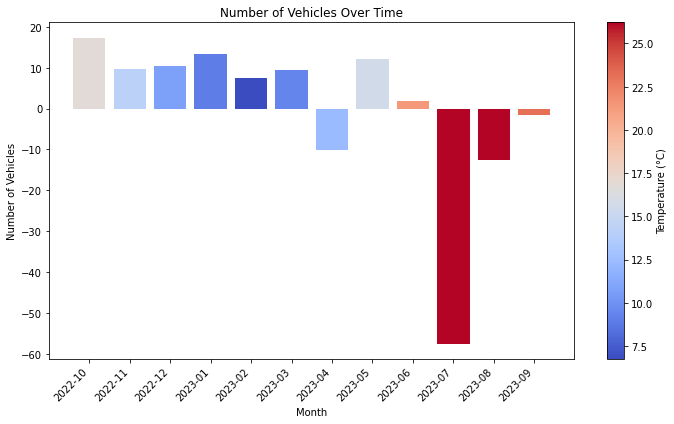

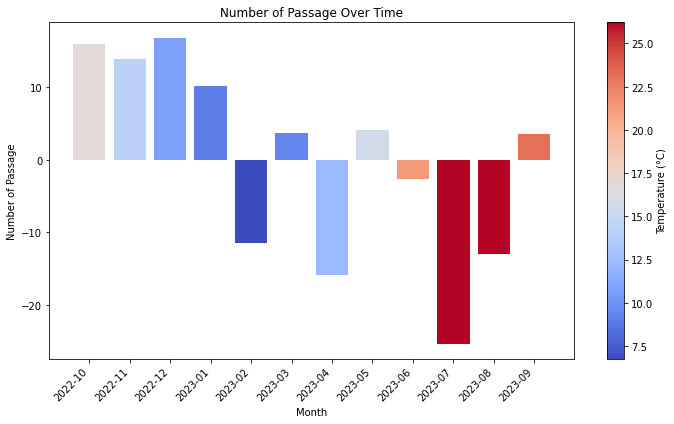

In [35]:
monthly_temp_change('Number of Vehicles','Number of Vehicles Over Time','traffic_change_percentage')
monthly_temp_change('Number of Passage','Number of Passage Over Time','passage_change_percentage')

#### Analysis of Cross-Relationships in Weather Conditions and Transportation

Studying the relationships formed by cross-conditions between data can be beneficial. In this context, the cross-relationships of four weather conditions were examined based on both vehicle traffic and total usage of public transportation. Additionally, a cross-relationship analysis was conducted for two weather conditions specific to public transportation vehicles.

In [36]:
def plot_scatter(x, y, hue, size, data, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, hue=hue, size=size, data=data, palette='coolwarm', sizes=(50, 200))
    plt.title(title)
    plt.show()

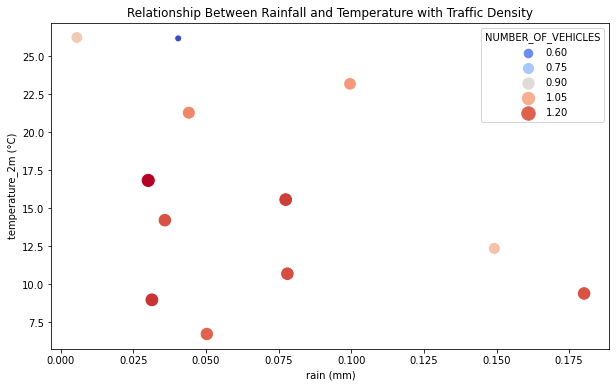

In [37]:
plot_scatter('rain (mm)', 'temperature_2m (°C)', 'NUMBER_OF_VEHICLES', 'NUMBER_OF_VEHICLES', df_monthly, 'Relationship Between Rainfall and Temperature with Traffic Density')

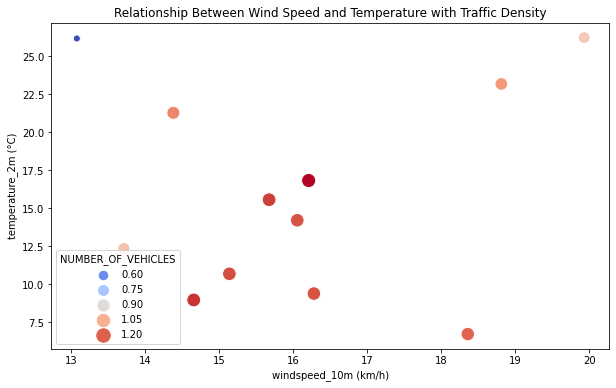

In [38]:
plot_scatter('windspeed_10m (km/h)', 'temperature_2m (°C)', 'NUMBER_OF_VEHICLES', 'NUMBER_OF_VEHICLES', df_monthly, 'Relationship Between Wind Speed and Temperature with Traffic Density')

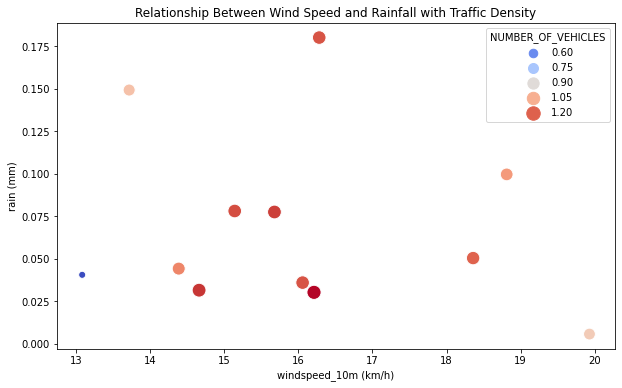

In [39]:
plot_scatter('windspeed_10m (km/h)', 'rain (mm)', 'NUMBER_OF_VEHICLES', 'NUMBER_OF_VEHICLES', df_monthly, 'Relationship Between Wind Speed and Rainfall with Traffic Density')

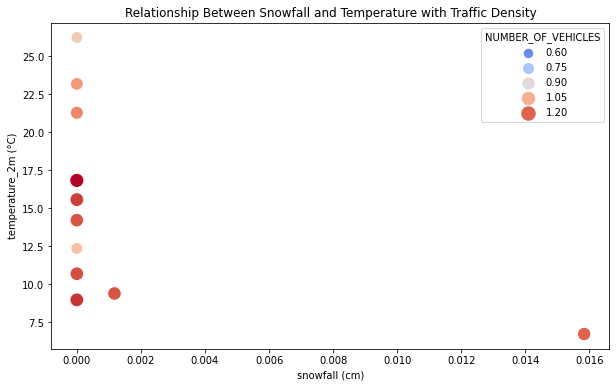

In [40]:
plot_scatter('snowfall (cm)', 'temperature_2m (°C)', 'NUMBER_OF_VEHICLES', 'NUMBER_OF_VEHICLES', df_monthly, 'Relationship Between Snowfall and Temperature with Traffic Density')

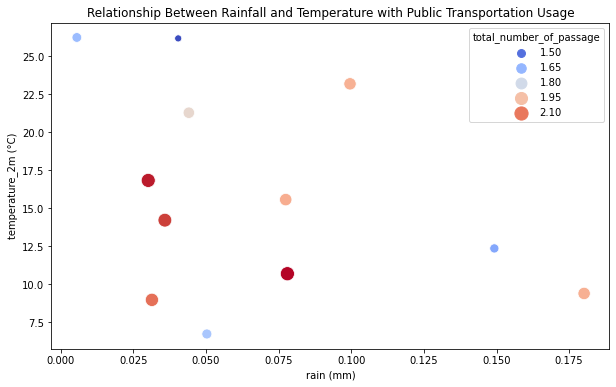

In [41]:
plot_scatter('rain (mm)', 'temperature_2m (°C)', 'total_number_of_passage', 'total_number_of_passage', df_monthly, 'Relationship Between Rainfall and Temperature with Public Transportation Usage')

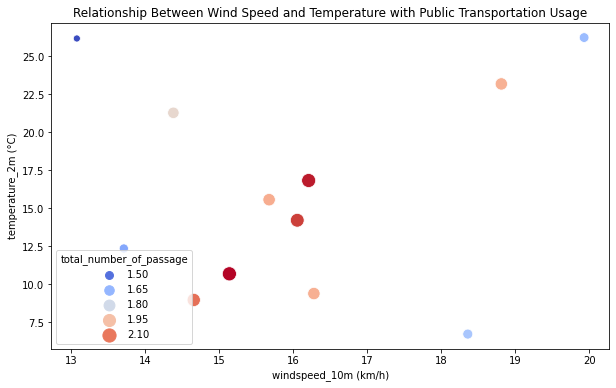

In [42]:
plot_scatter('windspeed_10m (km/h)', 'temperature_2m (°C)', 'total_number_of_passage', 'total_number_of_passage', df_monthly, 'Relationship Between Wind Speed and Temperature with Public Transportation Usage')

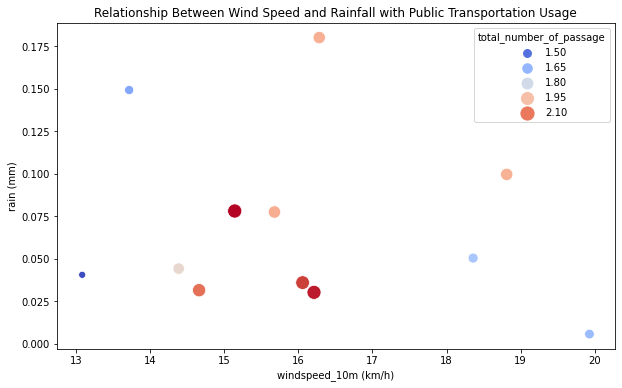

In [43]:
plot_scatter('windspeed_10m (km/h)', 'rain (mm)', 'total_number_of_passage', 'total_number_of_passage', df_monthly, 'Relationship Between Wind Speed and Rainfall with Public Transportation Usage')

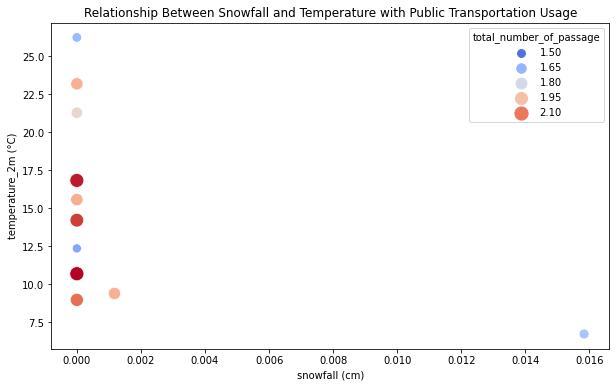

In [44]:
plot_scatter('snowfall (cm)', 'temperature_2m (°C)', 'total_number_of_passage', 'total_number_of_passage', df_monthly, 'Relationship Between Snowfall and Temperature with Public Transportation Usage')

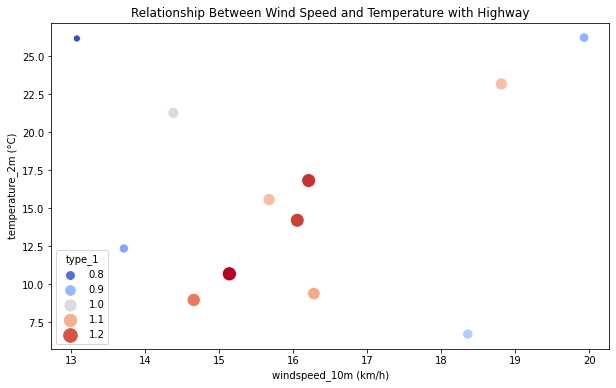

In [45]:
plot_scatter('windspeed_10m (km/h)', 'temperature_2m (°C)', 'type_1', 'type_1', df_monthly, 'Relationship Between Wind Speed and Temperature with Highway')

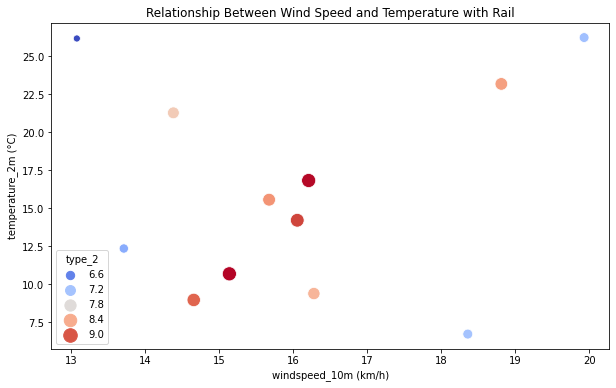

In [46]:
plot_scatter('windspeed_10m (km/h)', 'temperature_2m (°C)', 'type_2', 'type_2', df_monthly, 'Relationship Between Wind Speed and Temperature with Rail')

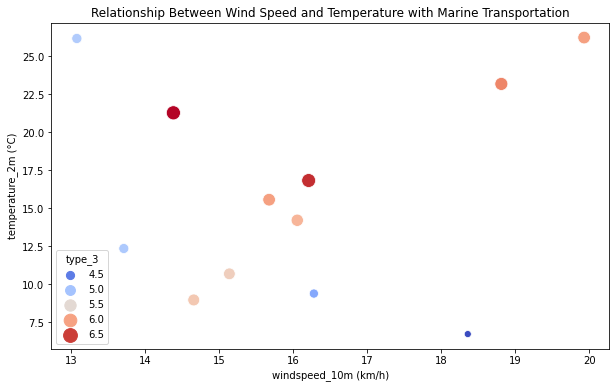

In [47]:
plot_scatter('windspeed_10m (km/h)', 'temperature_2m (°C)', 'type_3', 'type_3', df_monthly, 'Relationship Between Wind Speed and Temperature with Marine Transportation')

### 3.3 Correlation Analysis and Modeling
#### Data manipulation for analysis.

While examining tables with monthly data, there is no issue with using the current month's data as more general observations were made. However, when training a prediction model, it can be challenging to make decisions based on the current moment's data. For a model to be trained more accurately and realistically, it should be able to make predictions based on events that occurred before itself. If such predictions are possible, actions can be taken accordingly. Therefore, lagged records of the data have been created and prepared for modeling. The goal here is to predict the number of passengers on trains based on, for example, the weather conditions one hour ago.

In [48]:
df_hourly['NUMBER_OF_VEHICLES_lag'] = df_hourly['NUMBER_OF_VEHICLES'].shift(1)
df_hourly['type_1_lag'] = df_hourly['type_1'].shift(1)
df_hourly['type_2_lag'] = df_hourly['type_2'].shift(1)
df_hourly['type_3_lag'] = df_hourly['type_3'].shift(1)
df_hourly['total_number_of_passage_lag'] = df_hourly['total_number_of_passage'].shift(1)
df_hourly['temperature_2m_lag'] = df_hourly['temperature_2m (°C)'].shift(1)
df_hourly['relativehumidity_2m_lag'] = df_hourly['relativehumidity_2m (%)'].shift(1)
df_hourly['rain_lag'] = df_hourly['rain (mm)'].shift(1)
df_hourly['snowfall_lag'] = df_hourly['snowfall (cm)'].shift(1)
df_hourly['windspeed_10m_lag'] = df_hourly['windspeed_10m (km/h)'].shift(1)
df_hourly = df_hourly.iloc[1:]

df_hourly = df_hourly.reset_index(drop=True)

In [49]:
df_daily['NUMBER_OF_VEHICLES_lag'] = df_daily['NUMBER_OF_VEHICLES'].shift(1)
df_daily['type_1_lag'] = df_daily['type_1'].shift(1)
df_daily['type_2_lag'] = df_daily['type_2'].shift(1)
df_daily['type_3_lag'] = df_daily['type_3'].shift(1)
df_daily['total_number_of_passage_lag'] = df_daily['total_number_of_passage'].shift(1)
df_daily['temperature_2m_lag'] = df_daily['temperature_2m (°C)'].shift(1)
df_daily['relativehumidity_2m_lag'] = df_daily['relativehumidity_2m (%)'].shift(1)
df_daily['rain_lag'] = df_daily['rain (mm)'].shift(1)
df_daily['snowfall_lag'] = df_daily['snowfall (cm)'].shift(1)
df_daily['windspeed_10m_lag'] = df_daily['windspeed_10m (km/h)'].shift(1)
df_daily = df_daily.iloc[1:]
df_daily = df_daily.reset_index(drop=True)

#### Correlation Analysis

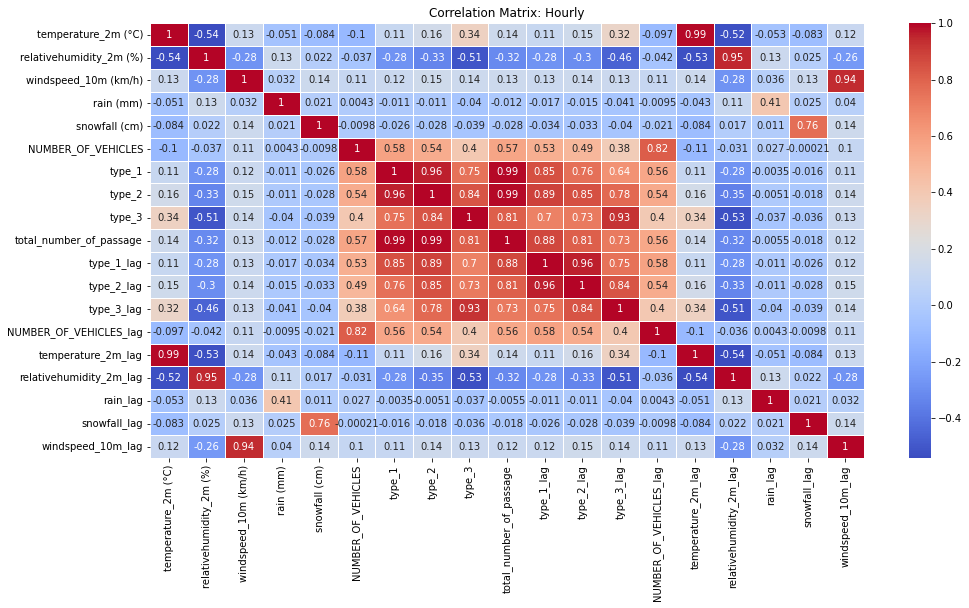

In [50]:
correlation_matrix = df_hourly[['temperature_2m (°C)','relativehumidity_2m (%)', 'windspeed_10m (km/h)', 'rain (mm)', 'snowfall (cm)', 'NUMBER_OF_VEHICLES', 'type_1', 'type_2', 'type_3', 'total_number_of_passage','type_1_lag', 'type_2_lag', 'type_3_lag','NUMBER_OF_VEHICLES_lag','temperature_2m_lag','relativehumidity_2m_lag','rain_lag','snowfall_lag','windspeed_10m_lag']].corr()
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix: {}'.format('Hourly'))
plt.show()

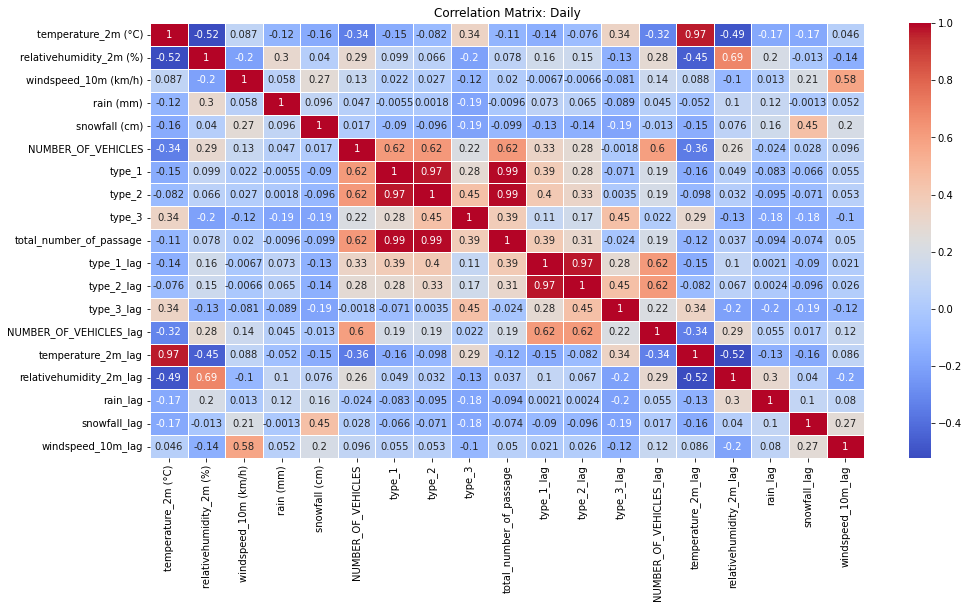

In [51]:
correlation_matrix = df_daily[['temperature_2m (°C)','relativehumidity_2m (%)', 'windspeed_10m (km/h)', 'rain (mm)', 'snowfall (cm)', 'NUMBER_OF_VEHICLES', 'type_1', 'type_2', 'type_3', 'total_number_of_passage','type_1_lag', 'type_2_lag', 'type_3_lag','NUMBER_OF_VEHICLES_lag','temperature_2m_lag','relativehumidity_2m_lag','rain_lag','snowfall_lag','windspeed_10m_lag']].corr()
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix: {}'.format('Daily'))
plt.show()

#### Model Training and Results

Predictions are made by training an XGBRegressor model. During model training, appropriate parameters are decided for each prediction and training data using grid_search, as each prediction and training data will be different. As a result, two different graphs are created and printed: one showing the performance change of the model based on its iterations, and the other indicating the importance ranking of features for the model.

In [52]:
def model(feature_,df):
    y = df[feature_]

    X = df[['type_1_lag', 'type_2_lag', 'type_3_lag','NUMBER_OF_VEHICLES_lag','temperature_2m_lag','relativehumidity_2m_lag','rain_lag','snowfall_lag','windspeed_10m_lag']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2]
    }

    xgb_model = XGBRegressor()

    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    best_xgb_model = XGBRegressor(n_estimators=best_params['n_estimators'], 
                                  max_depth=best_params['max_depth'], 
                                  learning_rate=best_params['learning_rate'],
                                 verbose=False)
    best_xgb_model.set_params(eval_metric='rmse')  

    evals = [(X_train, y_train), (X_test, y_test)]
    best_xgb_model.fit(X_train, y_train, eval_set=evals, verbose=False)

    results = best_xgb_model.evals_result()

    train_rmse = results['validation_0']['rmse']
    test_rmse = results['validation_1']['rmse']

    plt.figure(figsize=(10, 6))
    plt.plot(train_rmse, label='Train RMSE')
    plt.plot(test_rmse, label='Test RMSE')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Performance in the XGBoost Model Iteration Process')
    plt.legend()
    plt.show()
    
    plot_importance(best_xgb_model, importance_type='weight', max_num_features=10)  
    plt.show()


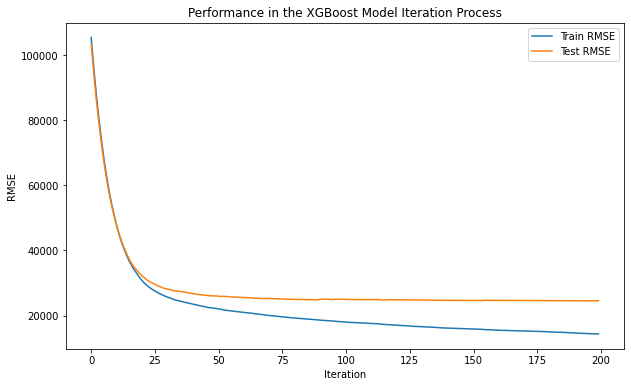

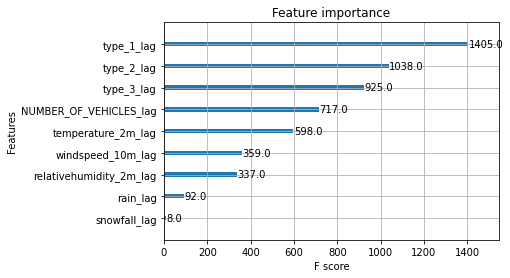

In [53]:
model('type_1',df_hourly)

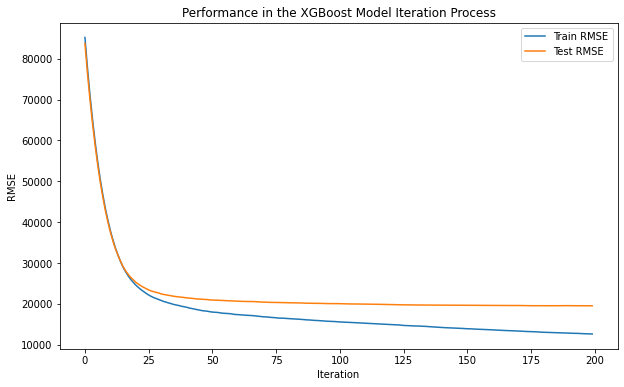

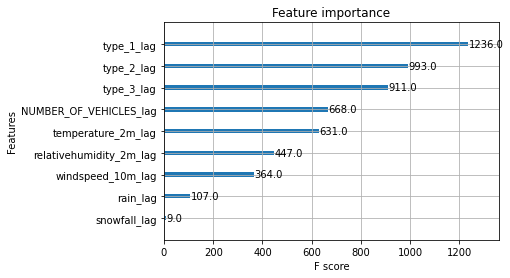

In [54]:
model('type_2',df_hourly)

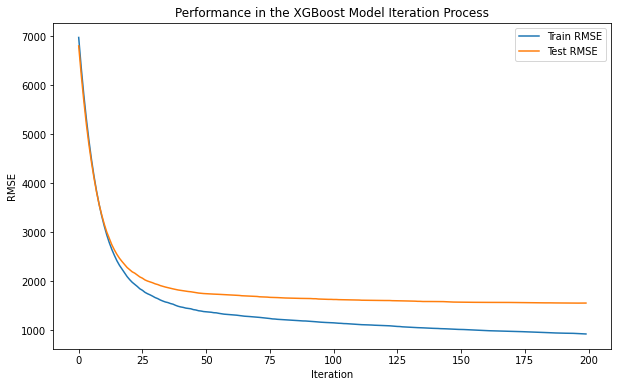

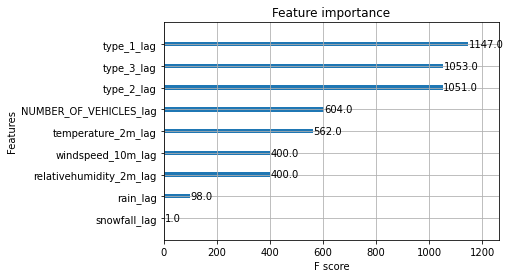

In [55]:
model('type_3',df_hourly)

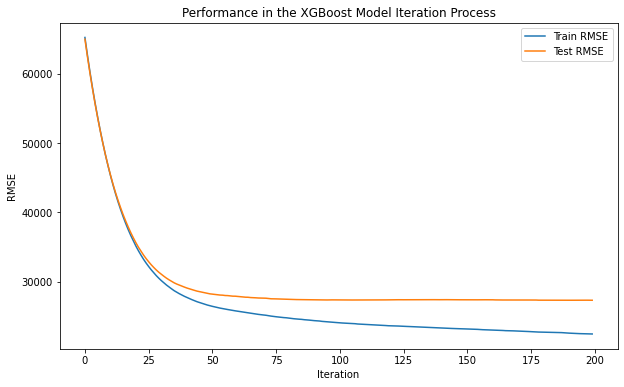

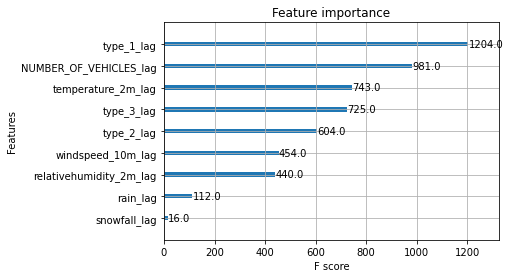

In [56]:
model('NUMBER_OF_VEHICLES',df_hourly)

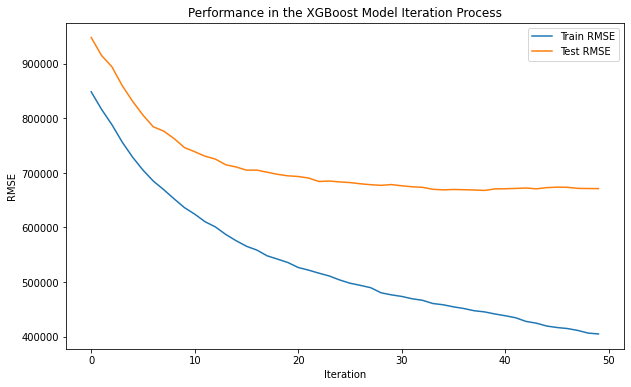

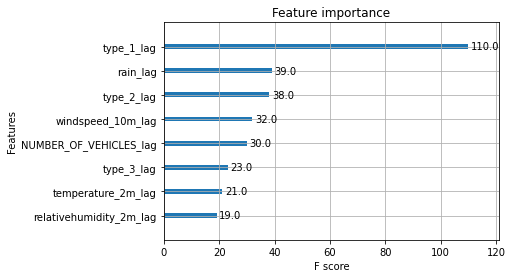

In [57]:
model('type_1',df_daily)

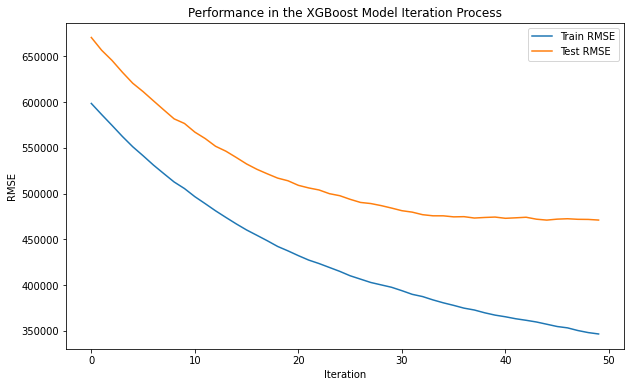

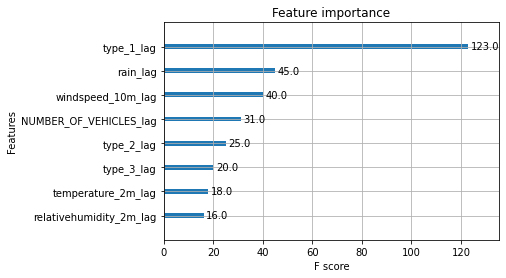

In [58]:
model('type_2',df_daily)

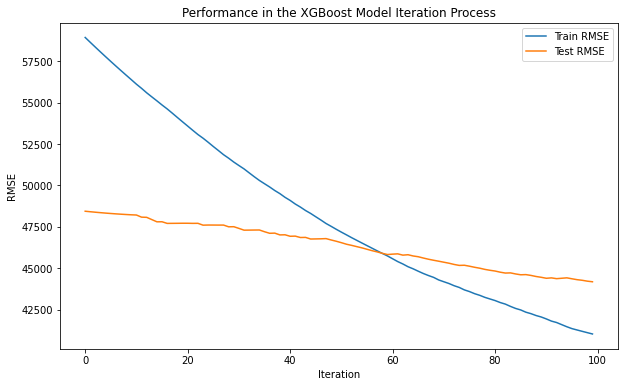

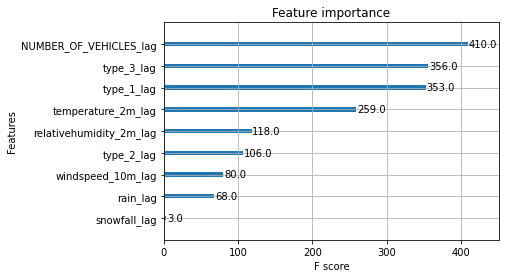

In [59]:
model('type_3',df_daily)

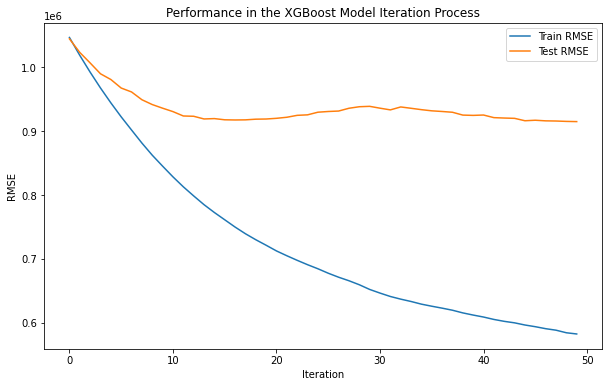

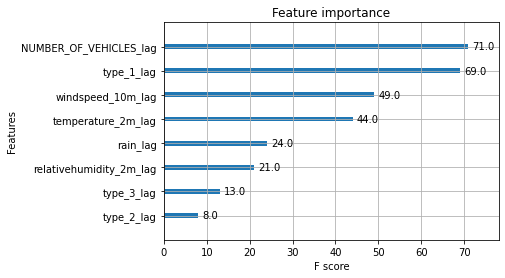

In [60]:
model('NUMBER_OF_VEHICLES',df_daily)

## 4. Discussion/Conclusion

In this project, the transportation problem of Istanbul has been addressed. Due to its diverse transportation options and the ability for people to switch between alternatives, various transportation alternatives are available for each route. In our research, the influence of weather conditions on the selection of these alternatives was investigated. We attempted to predict how much demand a particular mode of transportation might receive based on weather conditions and other transportation data. The project covers end-to-end processes, including creating a pipeline, data manipulation, data exploration, data analysis, and modeling. Throughout all these stages, various analyses were conducted to find answers to the problem's questions, and opportunities and challenges were encountered.

Before modeling and correlation analysis, some graphs were created to gain insights into the relationships between variables at a general level. While some relationships are noticeable in certain graphs, some variables may appear meaningless on the graph for certain types of transportation. All of these aspects will be discussed individually.

### Monthly Analysis of Transportation Type and Temperatur
When both public transportation and vehicles in traffic are examined, a decrease in demand is observed in both modes of transportation when the temperature significantly increases. However, in public transportation usage, unlike in vehicle traffic, a decrease in demand is also observed in cases where temperatures are significantly above or below the normal range. So, there is a decline in demand for public transportation when the temperature goes significantly above or below the average.

### Vehicle Traffic Analysis

1. **Rainfall and Temperature**
   - In the analysis of monthly temperature, it is observed that, besides the decrease in the number of vehicles as temperature increases, the influence of rainfall and temperature on the number of vehicles is not clearly discernible from the graph.

2. **Wind Speed and Temperature**
   - The graph indicates a concentration of Wind Speed between 14-17, where demand is high. However, outside this range, an increase or decrease in Wind Speed results in a decrease in the number of vehicles. In windy weather, different transportation modes might be preferred, as a decrease in Wind Speed correlates with a decrease in vehicle traffic in similar temperature conditions.

3. **Wind Speed and Rainfall**
   - The graph shows a similar concentration of the highest number of vehicles at Wind Speed between 14-17. Interestingly, when Wind Speed is close, the amount of rainfall does not significantly affect the number of vehicles in traffic.

4. **Snowfall and Temperature**
   - There is a clear natural correlation between Snowfall and Temperature. While the graph may not provide a detailed analysis due to Istanbul's infrequent snowfall, it suggests that during snowfall, the number of vehicles in traffic tends to exceed the average.

### Public Transportation Analysis

The aim is to create a forecast with monthly data for public transportation. However, hourly data and vehicle preferences should also be considered for a comprehensive analysis in correlation and modeling. For instance, during windy weather, ferry transportation may not be available or safe, leading to a shift towards alternative options such as the metro.

1. **Rainfall and Temperature**
   - The graph suggests that demand for public transportation decreases significantly when temperature is very low or high. This aligns with the previous analysis focusing only on temperature. However, analyzing situations where both temperature and rainfall influence demand simultaneously is challenging from monthly data. Further detailed results can be obtained with hourly data or vehicle-specific analyses.

2. **Wind Speed and Temperature**
   - The graph suggests that both Wind Speed and Temperature have peak demand during average values. An increase in temperature results in an increase in demand, while the effect of wind speed is not clear from the graph.

3. **Wind Speed and Rainfall**
   - Overall, the graph shows high demand at average values. Additionally, an increase in Rainfall for similar Wind Speed values leads to a decrease in demand.

4. **Snowfall and Temperature**
   - Although there are few instances of snowfall, it is evident from the observed cases that demand is significantly lower during snowy conditions.

### Transportation Mode-Specific Impact of Wind Speed and Temperature in Public Transportation

For public transportation modes such as Highway, Rail, and Marine Transportation, similar results are observed in the cross-analysis of Wind Speed and Temperature. However, there are diverging points for Marine Transportation. As temperature decreases, the demand for Marine Transportation decreases, and vice versa. Additionally, in low temperatures, an increase in wind speed leads to a decrease in demand, while in high temperatures, an increase in wind speed increases demand.

### Correlation Analysis

When examining the correlation table, a negative effect of temperature on the number of vehicles is observed, while a positive correlation is evident for public transportation. Especially, the increase in temperature has a much more positive impact on sea transportation compared to other modes of transportation. Relative humidity has a negative correlation for each type of transportation, but it notably influences sea transportation. When examining the effect of wind speed, it can be inferred that it has a close level of positive impact for each mode of transportation. Rain has a slightly negative correlation for public transportation vehicles, while it has a positive correlation for the number of vehicles in traffic. This can be interpreted as people slightly preferring their own vehicles when it rains. Snow has a negative correlation with all types of transportation and, to a small extent, affects sea transportation the most. There is a high positive correlation between different modes of transportation, indicating that even in congestion, demand is distributed among various transportation types.

In conclusion, based on the correlation table:
Sea transportation is the most weather-dependent mode of transportation. Demand decreases in relatively adverse weather conditions, while it increases when the temperature rises and the weather is relatively better.
Overall, an increase in humidity and snow may lead to a decrease in demand for all types of transportation.
Finally, during rainy weather, people prefer to use their own vehicles, while they tend to use public transportation as temperatures increase.

Positive correlations exist for some variables, while negative correlations exist for others. However, as seen in monthly data, extreme situations such as a significant increase or decrease in temperatures lead to a decrease in demand for public transportation. Here, explaining solely through correlation might be challenging. Therefore, a machine learning model has been created to examine the predictive accuracy of the model and which variables it prioritizes when making predictions.

### Prediction Model

Finally, the project was completed by establishing a model to predict future transportation demands. For demand prediction, a total of 8 models were built separately for each of the 4 transportation types, utilizing daily and hourly data. The expectation was to predict the current situation using the data from the previous time period for the models. Considering the possibility that different parameters might perform well for each variable and data type, a small grid search was conducted for each model to use the most suitable parameters. For interpreting the established models, two output graphs were created, showing the performance in each iteration during model training and the importance ranking of variables used by the models in decision-making.

According to the results of the established model, making predictions for daily data seems to be somewhat less successful initially, but the model's performance improves more rapidly in hourly data as the iterations progress after the model is first trained. Additionally, the difference between test and train data is often significant for daily data. Therefore, the model built for daily data is expected to perform poorly in the test data and consequently exhibit poor performance in a live system.

In the models created with hourly data, significant improvement is observed in the first 25 iterations. Between the 25th and 50th iterations, optimal results are obtained in both the train data and there is no widening gap between test and train data. Therefore, stopping the training of the model for hourly data at the 50th iteration to prevent overfitting is reasonable.

One crucial aspect of the model results is the feature importance, as it reveals which factors affect demand. Notably, for public transportation, the top 5 importance rankings for Highway and Rail are, respectively, the past hour's Highway data, the past hour's Rail data, Marine Transportation in the past hour, the number of vehicles in the past hour, and the past hour's air temperature. For Marine Transportation, the order shifts slightly with Rail, prioritizing its own type of past data a bit more, but since the difference is not substantial, it can be said that the top 5 variables for public transportation are similar.

In terms of weather conditions for public transportation, the priority rankings for Highway and Marine Transportation are similar, while Rail differs slightly. For Highway and Marine Transportation, past hour's wind speed and relative humidity are prioritized, while for Rail, it is the opposite. This is in line with the correlation analysis, where relative humidity had the most negative correlation with Marine Transportation.

In the model created for NUMBER OF VEHICLES, similar performance results are observed in a similar iteration for training. In the feature importance section, the highest importance for prediction is given to the past hour's Highway data. The second step includes the number of vehicles in the past hour. Weather conditions play a slightly more significant role in this model, with temperature data from the past hour ranking third, just before Rail and Marine Transportation.

Rain and snow are consistently observed as the least important variables in each model. The scarcity of data containing snow may have played a significant role in this observation.


### Challenges and Opportunities

The fact that Highway is the most important variable in every model can be explored from a domain-specific perspective. Determining why it is the most crucial variable in all cases can be challenging based solely on the data.

The project was conducted throughout Istanbul, where demand varies significantly across different regions. Predicting a general increase or decrease in demand may not yield accurate results. Therefore, a regional analysis may be necessary to provide more insights.

The project utilized one year of data, and conclusions were drawn solely from existing data. However, increasing the dataset might help mitigate the impact of specific events occurring in that particular year.

To enhance the project, more detailed information about Istanbul is essential. For instance, understanding how many people are obligated to travel daily, regardless of changing weather conditions, such as those who need to commute to work or school. Additionally, incorporating holiday dates in Istanbul could be beneficial. For example, there is a negative correlation between traffic and air temperature; however, during summer months, schools are closed, influencing a reduction in traffic.

By incorporating broader datasets and domain knowledge about Istanbul, it is possible to enhance the demand prediction model. Developing the project to accurately forecast demand in the right locations can increase satisfaction among Istanbul residents and potentially lead to transportation savings. For instance, adjusting subway intervals from 5 to 10 minutes during less crowded periods can save resources, while increasing frequency to every 3 minutes during peak times can enhance passenger satisfaction.

Focusing on flexible solutions within the scope of this project can yield additional benefits. For example, there are subway lines in Istanbul equipped with driverless technology, allowing for flexible adjustments to service hours. Ensuring passenger satisfaction through such flexibility may increase preference for metro transportation, potentially providing an advantage over road traffic. Detailed planning, such as addressing the decline in public transportation demand during summer months, can lead to increased efficiency by scheduling personnel training or leave during these periods.